In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score as sil_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import clone

## Data location

https://archive.ics.uci.edu/ml/datasets/detection_of_IoT_botnet_attacks_N_BaIoT

## Findings so far

If we split the data randomly into ten rounds and retrain every round the performance stays near 100\%. But if we start with an initial model that has seen some of every attack, iterate over the attacks each round and retrain each round performance craters. If we don't retrain each round, performance still craters. 

Defense policies for iterated game:
- retraining decision
- - never retrain
- - always retrain
- - only retrain when a threshold on perf is passed
- retraining method
- - fixed model
- - mixed model, max perf on validation data
- - mixed model, max posterior diff over those passing threshold on perf

Offense policies for iterated game:
- randomly: sample from attacks, iterate over attacks, switch between type of botnet
- greedy: sample only from attack with highests win-rate in previous round
- (relaxed greedy) clustering: sample from attacks within highest win-rate cluster in previous round

## Load Data

In [2]:
devices = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor',
          'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera',
          'Samsung_SNH_1011_WHT_Security_Camera', 'SimpleHome_XCS7_1002_WHT_Security_Camera',
          'SimpleHome_XCS7_1003_WHT_Security_Camera']

In [3]:
# load benign, mirai, and gafgyt data into single df with 'Class' label column
def load_device_data(device):
    
    # load benign data into df
    benign_path = 'Data/' + device + '/benign_traffic.csv'
    df = pd.read_csv(benign_path)
    df['Multi Class'] = 'benign'
    
    # load mirai data into df
    if device != 'Ennio_Doorbell' and device != 'Samsung_SNH_1011_WHT_Security_Camera':
        mirai_path = 'Data/' + device + '/mirai_attacks/'
        for label in ['ack', 'scan', 'syn', 'udp', 'udpplain']:
            temp = pd.read_csv(mirai_path + label + '.csv')
            temp['Multi Class'] = 'mirai ' + label
            df = pd.concat([df, temp], ignore_index=True)
    
    # load gafgyt data into df
    gafgyt_path = 'Data/' + device + '/gafgyt_attacks/'
    for label in ['combo', 'junk', 'scan', 'tcp', 'udp']:
        temp = pd.read_csv(gafgyt_path + label + '.csv')
        temp['Multi Class'] = 'gafgyt ' + label
        df = pd.concat([df, temp], ignore_index=True)
    
    # add binary class label
    df['Binary Class'] = [i if i == 'benign' else 'malicious' for i in df['Multi Class']]
    
    # return
    return df

In [66]:
df = load_device_data(devices[0])

In [67]:
df.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Multi Class,Binary Class
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,benign,benign
1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,...,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0,benign,benign
2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,1.996939,...,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0,benign,benign
3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,...,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,benign,benign
4,1.680223,172.140917,18487.448750,1.793580,182.560279,18928.175300,1.925828,193.165753,19153.795810,1.992323,...,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,benign,benign


In [68]:
np.unique(df['Multi Class'])

array(['benign', 'gafgyt combo', 'gafgyt junk', 'gafgyt scan',
       'gafgyt tcp', 'gafgyt udp', 'mirai ack', 'mirai scan', 'mirai syn',
       'mirai udp', 'mirai udpplain'], dtype=object)

In [69]:
len(df.index)

1018298

## Add Round ID to Dataframe

In [70]:
df['Round'] = [int(np.random.rand()*10) for i in range(len(df.index))]

In [71]:
for i in range(10):
    print(np.unique(df[df['Round'] == i]['Multi Class'], return_counts=True)[1])

[ 4935  5884  2887  2985  9202 10494 10236 10825 12334 23710  8133]
[ 5006  5939  2942  2980  9273 10585 10193 10851 12140 23854  8281]
[ 4955  5915  2940  3021  9061 10648 10361 10744 12192 23676  8117]
[ 4975  5847  2910  2906  9356 10630 10278 10678 12358 23765  8207]
[ 4947  6106  2908  2996  9204 10693 10148 10805 12192 23581  8239]
[ 4981  5945  2906  2997  9075 10616  9987 10839 12082 24017  8075]
[ 4923  6053  2924  2957  9368 10516 10253 10799 12226 23533  8197]
[ 4932  5984  2782  2982  9228 10606 10111 10695 12317 23771  8166]
[ 4942  5999  2893  3018  9130 10576 10284 10841 12363 23737  8396]
[ 4952  6046  2976  3007  9244 10510 10344 10608 12369 24021  8171]


In [72]:
df.columns

Index(['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance',
       'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance',
       'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance',
       'MI_dir_L0.1_weight',
       ...
       'HpHp_L0.01_weight', 'HpHp_L0.01_mean', 'HpHp_L0.01_std',
       'HpHp_L0.01_magnitude', 'HpHp_L0.01_radius', 'HpHp_L0.01_covariance',
       'HpHp_L0.01_pcc', 'Multi Class', 'Binary Class', 'Round'],
      dtype='object', length=118)

In [73]:
u_df = df

## Data to Test Policies

In [11]:
x = df[df.columns[0:-3]]
y = df[df.columns[-3::]]

In [12]:
y.head()

,Multi Class,Binary Class,Round
0,benign,benign,8
1,benign,benign,4
2,benign,benign,4
3,benign,benign,4
4,benign,benign,7


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y['Multi Class'], random_state=42)

In [14]:
forest = RandomForestClassifier(random_state=0)
forest.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

## Defense Policies

Defense policies for iterated game:
- retraining decision
- - never retrain
- - always retrain
- - only retrain when a threshold on perf is passed
- retraining method
- - fixed model
- - mixed model, max perf on validation data
- - mixed model, max posterior diff on validation data
- - mixed model, max posterior diff over those passing threshold on perf

In [129]:
# decision_key's: 'never', 'always, incremental', 'always, from scratch', 'threshold, incremental'
#                 'threshold, from scratch'
# method_key's: 'fixed', 'max perf', 'max diff', 'threshold'
def retraining_decision(clf, x, y, prev_acc, t=0.8, decision_key='never', method_key='fixed'):
    # never train
    if decision_key == 'never':
        return clf
    
    # always retrain
    if decision_key == 'always, incremental':
        return retraining_method(clf, x, y, prev_acc, t, method_key)
        
    if decision_key == 'always, from scratch':
        clf_new = clone(clf)
        return retraining_method(clf_new, x, y, prev_acc, t, method_key)
    
    # retrain if threshold is passed
    if 'threshold' in decision_key:
        if prev_acc >= t:
            return clf
        else:
            if 'incremental' in decision_key:
                return retraining_method(clf, x, y, prev_acc, t, key=method_key)
            else:
                clf_new = clone(clf)
                return retraining_method(clf_new, x, y, prev_acc, t, key=method_key)
    
    # crash if invalid decision_key
    return "Bad Key"

def mixed_models(x, y):
    # NEED to MAKE SURE THESE ARE INITIALIZED WITH FULL OUTPUT SPACE, MAYBE PASS 
    # IN A SET OF INITIALIZED MODELS LIKE FOR THE SINGLE MODEL CASE
    forest1 = RandomForestClassifier(random_state=0)
    forest2 = RandomForestClassifier(random_state=1)
    forest3 = RandomForestClassifier(random_state=2)
    
    forest1.fit(x, y)
    forest2.fit(x, y)
    forest3.fit(x, y)
    
    return [forest1, forest2, forest3]
    

def retraining_method(clf, x, y, prev_acc, t, key):

    # only one model
    if key == 'fixed':
        clf.fit(x, y)
        return clf
    
    # picking from a bag of models...
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, random_state=42)
    models = mixed_models(x_tr, y_tr)
    
    # ... model with maximum performance
    if key == 'max perf':
        perfs = [balanced_accuracy_score(y_te, model.predict(y_te)) for model in models]
        return models[np.argmax(perfs)]
    
    # ... model with maximum posterior divergence from previous model
    if key == 'max diff':
        preds_prev = clf.predict(y_te)
        preds_models = [model.predict(x_te) for model in models]
        diffs = [np.median(preds_prev - preds_model) for preds_model in preds_models]
        return models[np.argmax(diffs)]
    
    # ... model with maximum posterior if performance drops
    if key == 'threshold':
        if prev_acc >= t:
            return clf
        else:
            retraining_method(clf, x, y, prev_acc, t, key='max diff')
    
    # crash if invalid decision key
    return "Bad Key"

## Offense Policies
Offense policies for iterated game:
- offense_policy_random: sample from attacks, iterate over attacks, switch between type of botnet
- offense_policy_greedy: sample only from attack with highests win-rate in previous round
- offense_policy_clustering: sample from attacks within highest win-rate cluster in previous round

In [126]:
def offense_policy_random(df, size, key='random sample'):
    # randomly sample from given df
    if key == 'random sample':
        return df.sample(size)
    
    # randomly sample a single attack from given df
    if key == 'random attack':
        choice = int(np.random.rand() * len(np.unique(df['Multi Class'])))
        choice = np.unique(df['Multi Class'])[choice]
        return df[df['Multi Class'] == choice].sample(size)
    
    # randomly sample a single botnet's attacks from a given df
    if key == 'random botnet':
        choice = int(np.random.rand()*2)
        if choice == 0:
            return df[df['Multi Class'].str.contains('gafgyt')].sample(size)
        else:
            return df[df['Multi Class'].str.contains('mirai')].sample(size)

        
def offense_policy_greedy(df, size, best_attack):
    # get only best attack
    return df[df['Multi Class'] == best_attack].sample(size)


def offense_policy_clustering(df, size, x_past, y_past, y_pred, round_id):
    
    def get_best_clusters(x):
        scores, clusterer = [], []
        # test cluster sizes 2, 3, 4
        for i in range(3):
            print('Fitting cluster')
            kmeans = KMeans(n_clusters=i+2, random_state=0).fit(x)
            clusterer.append(kmeans)
            scores.append(sil_score(x, kmeans.labels_))
        # return best fitted kmeans
        return clusterer[np.argmax(np.asarray(scores))]
    
    # get boolean for results
    correctness = [np.asarray(y_test)[i] == np.asarray(y_pred)[i] for i in range(len(y_test))]
    
    # get x
    x = df[df.columns[0:-3]]
    
    # fit PCA
    pca = PCA(n_components=2)
    scaler = StandardScaler().fit(x_past)
    x_s = scaler.transform(x_past)
    pca.fit(x_s)
    x_p = pca.transform(x_s)
    
    # cluster PCA
    kmeans = get_best_clusters(x_p)
    
    # plot clusters
    plt.scatter([i[0] for i in x_p], [i[1] for i in x_p], c=kmeans.labels_)
    plt.savefig('pca_round_' + str(round_id) + '.png', dpi=300)
    plt.show()
    
    # get clusters with highest win-rate:
    wins = []
    for i in np.unique(kmeans.labels_):
        correctness_c = [correctness[j] for j in kmeans.labels_ if j == i]
        wins.append(sum(correctness_c))
    best_cluster = np.unique(kmeans.labels_)[np.argmax(np.asarray(wins))]
    
    # get df for best_cluster
    df['Cluster'] = kmeans.predict(pca.transform(scaler.transform(x)))
    df[df['Cluster'] == best_cluster]
    df.drop(labels='Cluster', axis=1, inplace=True)
    return df.sample(size)

# keys: random sample, random attack, random botnet, greedy, clustering
def get_new_attacks(df, size, x_past, y_past, y_pred, round_id, key='greedy'):
    
    # get best attacks (drop benign)
    successful_attacks = [np.asarray(y_past)[j] for j in range(len(y_past)) if np.asarray(y_past)[j] != np.asarray(y_pred)[j]]
    successful_attacks = [sa for sa in successful_attacks if 'benign' not in sa]
    print('... ' + str(len(successful_attacks)) + ' Successful Attacks Last Round')
    
    # if there are no successful attacks randomly pick one, otherwise pick the best
    best_attack = df[df['Multi Class'] != 'benign']['Multi Class'].sample(1).values[0]
    if len(successful_attacks) > 0:
        best_attack = np.unique(successful_attacks)[np.argmax(np.unique(successful_attacks, return_counts=True)[1])]
    print('... ' + best_attack + ' is Last Round\'s Best Attack')
    
    # execute strategy
    if 'random' in key:
        return offense_policy_random(df, size, key=key)
    
    if key == 'greedy':
        return offense_policy_greedy(df, size, best_attack)
    
    if key == 'clustering':
        return offense_policy_greedy(df, size, x_past, y_past, y_pred, round_id)
    
    # crash on invalid key
    return "Bad Key"

In [18]:
offense_policy_random(df, 1000, 'random botnet')['Multi Class'].head(10)

851516      gafgyt tcp
876577      gafgyt tcp
998137      gafgyt udp
963859      gafgyt udp
809398     gafgyt scan
978139      gafgyt udp
879991      gafgyt tcp
799396     gafgyt scan
791013     gafgyt scan
1014138     gafgyt udp
Name: Multi Class, dtype: object

In [19]:
offense_policy_greedy(df, 1000, 'mirai ack')['Multi Class'].head(10)

89108     mirai ack
86418     mirai ack
66867     mirai ack
130354    mirai ack
55978     mirai ack
126671    mirai ack
51320     mirai ack
130002    mirai ack
83697     mirai ack
111512    mirai ack
Name: Multi Class, dtype: object

Fitting cluster
Fitting cluster
Fitting cluster


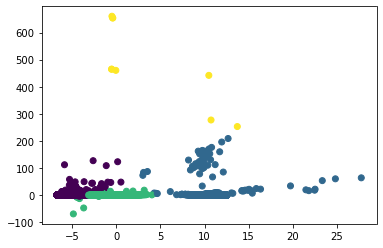

In [20]:
dft = offense_policy_clustering(df, 1000, x_test, y_test, forest.predict(x_test), 0)

In [21]:
dft['Multi Class'].head(10)

469022       mirai udp
597181       mirai udp
756521    gafgyt combo
338200       mirai syn
505389       mirai udp
483668       mirai udp
988454      gafgyt udp
429207       mirai udp
191088      mirai scan
524602       mirai udp
Name: Multi Class, dtype: object

## Experiments

In [84]:
# class totals in a given round r
r = 0
np.unique(u_df[u_df['Round'] == r]['Multi Class'], return_counts=True)

(array(['benign', 'gafgyt combo', 'gafgyt junk', 'gafgyt scan',
        'gafgyt tcp', 'gafgyt udp', 'mirai ack', 'mirai scan', 'mirai syn',
        'mirai udp', 'mirai udpplain'], dtype=object),
 array([ 4935,  5884,  2887,  2985,  9202, 10494, 10236, 10825, 12334,
        23710,  8133]))

# Notes

Bug found: defender gets 100% accuracy the simulation crashes because there are no "successful attacks" to sample from in the first few lines of the "get_new_attacks" function. This was addressed by initializing "best attack" with random attack.

Bug suspected: An issue not yet seen is that when retraining from scratch not all classes might be available when clf.fit() is called. That is, e.g., if only gafgyt junk was selected then when the current round's gafgyt junk attack sample and the benign sample are combined there are missing adversary classes. This doesn't cause an issue currently because the initial clf is trained with all classes, and clf is "sklearn.base.clone"'d when retraining from scratch. Therefore the output space has all classes even though many of those classes may not be available. Probably when multiple models are used they need to be initialized in a similar manner (i.e., in the 'mixed_models()' function.

In [130]:
# initialize model
init_df = u_df[u_df['Round'] == 0]
x, y = init_df[init_df.columns[0:-3]], init_df[init_df.columns[-3::]]
x_tr, x_te, y_tr, y_te = train_test_split(x, y['Multi Class'], random_state=42)

print('Botnet Iterated Games Simulation ...')
print('... Initializing')
clf = RandomForestClassifier(random_state=0)
clf.fit(x_tr, y_tr)
prev_acc = balanced_accuracy_score(y_te, clf.predict(x_te))
print('... Initial Score = ' + str(prev_acc))

# game parameters
benign_size = 4000

# defense strategy parameters
decision_key = 'always, from scratch'
method_key = 'fixed'
t = 0.8

# offense strategy parameters
offense_key = 'random sample'
size = 500

# intialize stores
balanced_accuracies = [prev_acc]

print('... Defense Strategy: ' + decision_key + ' | ' + method_key)
print('... Adversary Strategy: ' + offense_key + '\n')

# run next 9 rounds
for i in range(9):
    i += 1
    
    # print
    print('Round ' + str(i) + ' Starting ...')
    
    # run offensive strategy (get sample of attacks)
    df_attack = get_new_attacks(u_df[u_df['Round'] == i], size, x_te, y_te, clf.predict(x_te), i, offense_key)
    print('... New Attacks Selected by Adversary')
    
    # run defensive strategy (get new classifier)
    clf = retraining_decision(clf, x_te, y_te, prev_acc, t, decision_key, method_key)
    print('... New Classifier Selected by Defender')
    
    # conduct round
    print('... Conducting Round')
    
    # ... get this round's benign data
    df = u_df[u_df['Round'] == i]
    df = df[df['Multi Class'] == 'benign']
    df.sample(benign_size)
    
    # ... combine it with this round's attack data
    df = pd.concat([df, df_attack])
    x_te, y_te = df[df.columns[0:-3]], df[df.columns[-3::]]['Multi Class']
    
    # ... evaluate
    print('... Evaluating Performance')
    prev_acc = balanced_accuracy_score(y_te, clf.predict(x_te))
    balanced_accuracies.append(prev_acc)
    print('... Score = ' + str(prev_acc) + '\n')

Botnet Iterated Games Simulation ...
... Initializing
... Initial Score = 0.9994121861927444
... Defense Strategy: always, from scratch | fixed
... Adversary Strategy: random attack

Round 1 Starting ...
... 7 Successful Attacks Last Round
... gafgyt junk is Last Round's Best Attack
... New Attacks Selected by Adversary
... New Classifier Selected by Defender
... Conducting Round
... Evaluating Performance
... Score = 0.9989001198561727

Round 2 Starting ...
... 1 Successful Attacks Last Round
... gafgyt combo is Last Round's Best Attack


/Users/tyler/miniforge3/envs/tf_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


... New Attacks Selected by Adversary
... New Classifier Selected by Defender
... Conducting Round
... Evaluating Performance
... Score = 0.5

Round 3 Starting ...
... 500 Successful Attacks Last Round
... mirai syn is Last Round's Best Attack


/Users/tyler/miniforge3/envs/tf_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


... New Attacks Selected by Adversary
... New Classifier Selected by Defender
... Conducting Round
... Evaluating Performance
... Score = 0.5

Round 4 Starting ...
... 500 Successful Attacks Last Round
... gafgyt scan is Last Round's Best Attack


/Users/tyler/miniforge3/envs/tf_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


... New Attacks Selected by Adversary
... New Classifier Selected by Defender
... Conducting Round
... Evaluating Performance
... Score = 0.5

Round 5 Starting ...
... 500 Successful Attacks Last Round
... gafgyt tcp is Last Round's Best Attack
... New Attacks Selected by Adversary
... New Classifier Selected by Defender
... Conducting Round
... Evaluating Performance
... Score = 0.49989961855049186

Round 6 Starting ...
... 500 Successful Attacks Last Round
... mirai udp is Last Round's Best Attack


/Users/tyler/miniforge3/envs/tf_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


... New Attacks Selected by Adversary
... New Classifier Selected by Defender
... Conducting Round
... Evaluating Performance
... Score = 0.5

Round 7 Starting ...
... 500 Successful Attacks Last Round
... mirai ack is Last Round's Best Attack


/Users/tyler/miniforge3/envs/tf_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


... New Attacks Selected by Adversary
... New Classifier Selected by Defender
... Conducting Round
... Evaluating Performance
... Score = 0.5

Round 8 Starting ...
... 500 Successful Attacks Last Round
... gafgyt udp is Last Round's Best Attack
... New Attacks Selected by Adversary
... New Classifier Selected by Defender
... Conducting Round
... Evaluating Performance
... Score = 0.5

Round 9 Starting ...
... 500 Successful Attacks Last Round
... mirai syn is Last Round's Best Attack


/Users/tyler/miniforge3/envs/tf_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


... New Attacks Selected by Adversary
... New Classifier Selected by Defender
... Conducting Round
... Evaluating Performance
... Score = 1.0

